# 1. 지하철 일별 시간별 탑승객 현황

## 1.1 지하철 일별 시간별 탑승객 데이터 전처리

In [1]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 글꼴 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

import warnings
warnings.filterwarnings("ignore")

import holidays

# address
base_url = 'C:/Users/WD/Desktop/'
# 2022
df_22 =  pd.read_csv(f"{base_url}busan/2022.csv", encoding = 'cp949')
# 2023
df_23 =  pd.read_csv(f"{base_url}busan/2023.csv", encoding = 'cp949')
# 데이터 합치기
df = pd.concat([df_22, df_23])

# 2호선만 분석 진행
# 201-243 (장산 - 양산)
num = list(range(201,244))
df_line = df[df['역번호'].isin(num)]

# 공백 삭제
df_line['역명'] = df_line['역명'].str.replace(' ', '')

# 출퇴근 시간대 07-10, 17-19
df_line = df_line[['역명', '년월일', '요일', '구분', '합계','07시-08시', '08시-09시', '09시-10시','17시-18시','18시-19시','19시-20시']]

# 평일만 추출
week = ['월','화','수','목','금']
df_line_week = df_line[df_line['요일'].isin(week)]
df_line_week.reset_index(inplace = True,drop=True)

# 합계 부분 , 제거
def convert_to_integer(value):
    value = str(value).replace(',', '')
    try:
        return int(value)
    except ValueError:
        return np.nan

df_line_week['합계'] = df_line_week['합계'].map(convert_to_integer)

# 한국 공휴일 정보 로드
kr_holidays = holidays.KR

# 특정 연도의 공휴일 확인
kr_holidays_2022 = kr_holidays(2022)
kr_holidays_2023 = kr_holidays(2023)

holiday = []
# 2022, 2023 공휴일 리스트
for date, name in sorted(kr_holidays_2022.items()):
    holiday.append(date)
for date, name in sorted(kr_holidays_2023.items()):
    holiday.append(date)

# 데이터프레임에서 공휴일을 제외한 행 선택
df_line_week = df_line_week[~df_line_week['년월일'].astype('datetime64').isin(holiday)]

In [3]:
df_line_week.head(3)

,역명,년월일,요일,구분,합계,07시-08시,08시-09시,09시-10시,17시-18시,18시-19시,19시-20시
0,장산,2022-01-03,월,승차,13829,1185,1474,874,1137,1111,508
1,장산,2022-01-03,월,하차,13429,467,1068,834,1113,1625,1052
2,장산,2022-01-04,화,승차,14287,1143,1511,822,1232,1078,601


In [7]:
print(df_line_week.shape)

(28294, 11)


## 1.2 지하철 EDA

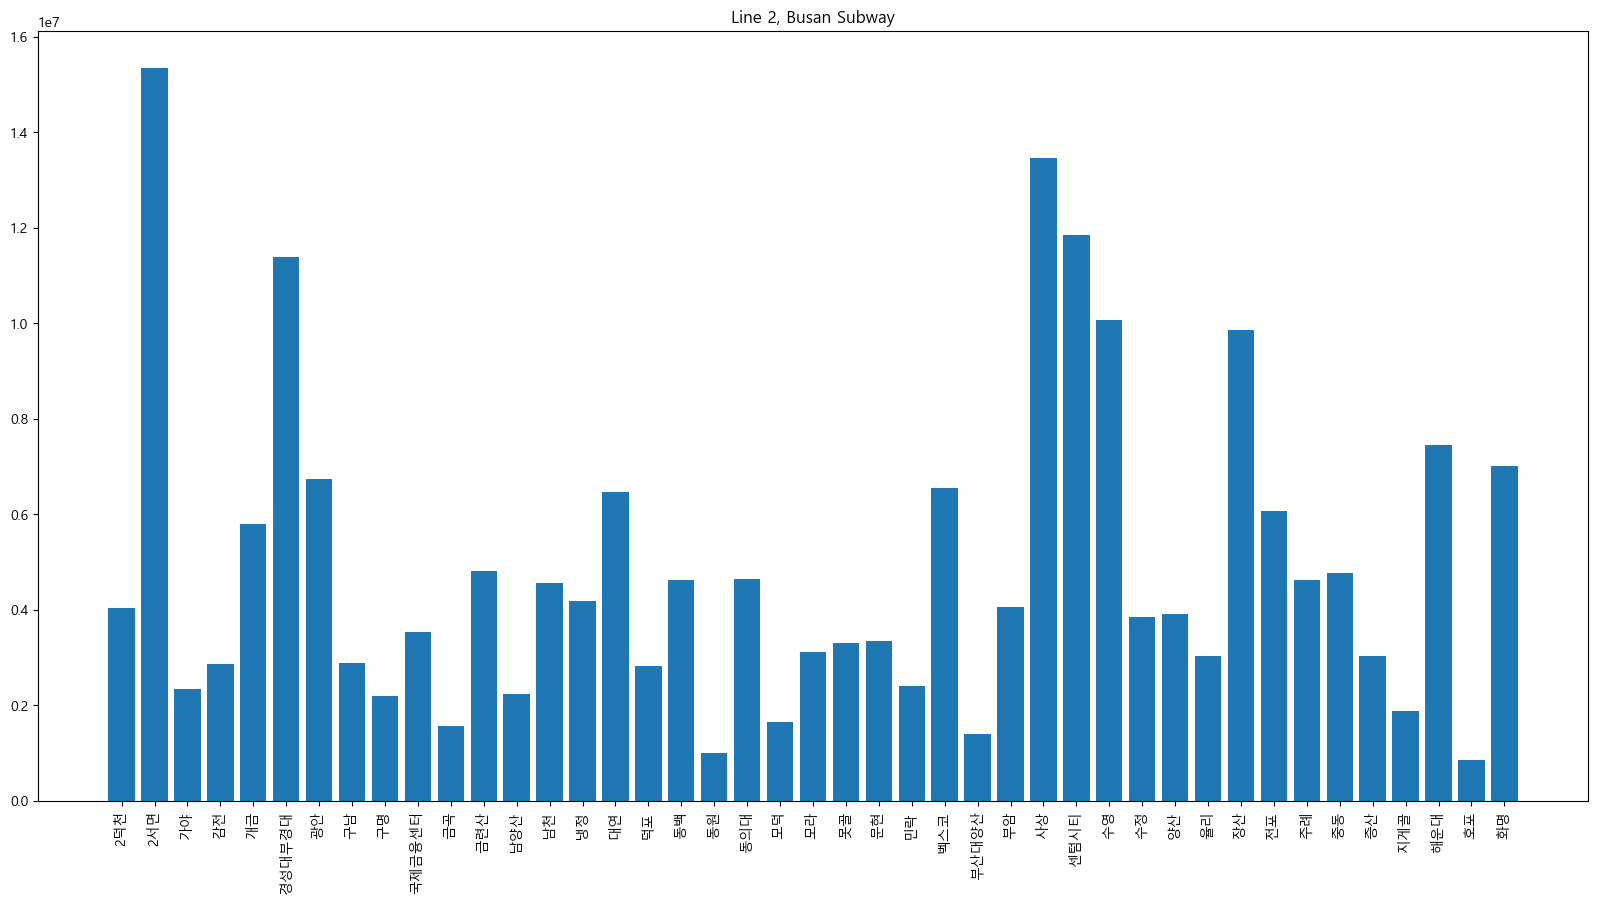

In [23]:
# 출퇴근 시간 탑승객 시각화
plt.figure(figsize=(20, 10))
plt.title('Line 2, Busan Subway')
plt.bar(df_line_week.groupby('역명').sum()['합계'].reset_index()['역명'], df_line_week.groupby('역명').sum()['합계'].reset_index()['합계'])
plt.xticks(rotation=90)
plt.show;

In [19]:
# 합계 상위 5개
df_line_week.groupby('역명').sum()['합계'].reset_index().sort_values(by='합계', ascending = False).head(5)

,역명,합계
1,2서면,15351731
28,사상,13455350
29,센텀시티,11842459
5,경성대부경대,11384263
30,수영,10076107


In [20]:
# 출퇴근 시간 탑승객이 많은 곳을 봤을 때 서면, 사상, 센텀시티, 경성대부경대, 수영으로 나온다.
# 센턴시티, 경성대부경대를 제외한 세곳은 환승역에 해당이 된다.
# 센텀시티, 경성대 부경대 중심으로 보기로 함

In [55]:
# 센텀시티
df_city_centum = df_line_week[df_line_week['역명'] == '센텀시티']
df_city_centum.head(3)

,역명,년월일,요일,구분,합계,07시-08시,08시-09시,09시-10시,17시-18시,18시-19시,19시-20시
2380,센텀시티,2022-01-03,월,승차,15664,345,561,346,1797,3278,1552
2381,센텀시티,2022-01-03,월,하차,15743,726,3027,2266,970,1012,504
2382,센텀시티,2022-01-04,화,승차,16227,351,585,386,1888,3363,1554


In [56]:
# 각 컬럼에 있는 값들을 문자열로 변환하고 쉼표(,) 제거하고 정수로 변환
columns_to_convert = ['합계', '07시-08시', '08시-09시', '09시-10시', '17시-18시', '18시-19시', '19시-20시']
for column in columns_to_convert:
    df_city_centum[column] = df_city_centum[column].astype(str).str.replace(',', '').astype(int)

In [57]:
df_city_centum['년월일'] = df_city_centum['년월일'].astype('datetime64')

In [58]:
# 출퇴근시간 합치기
df_city_centum['출근시간'] = df_city_centum['07시-08시'] + df_city_centum['08시-09시']+df_city_centum['09시-10시']
df_city_centum['퇴근시간'] = df_city_centum['17시-18시'] + df_city_centum['18시-19시']+df_city_centum['19시-20시']

In [59]:
# 승차 
centum_riding = df_city_centum[df_city_centum['구분'] == '승차']
# 하차
centum_quit = df_city_centum[df_city_centum['구분'] == '하차']

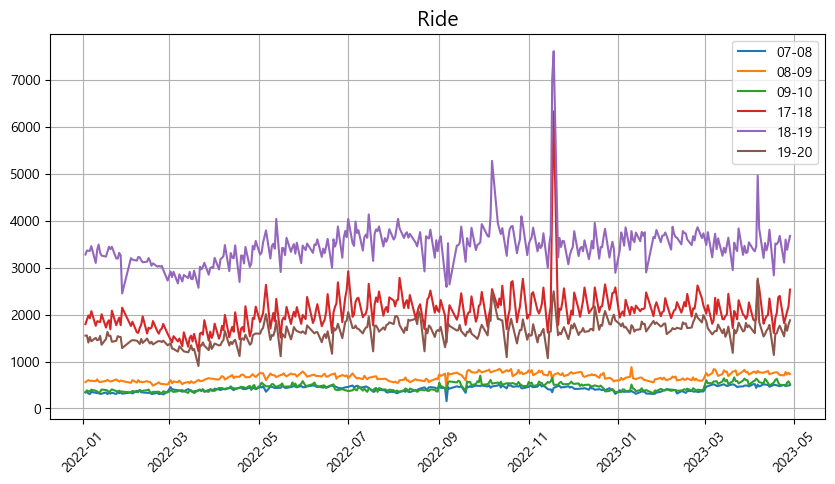

In [61]:
# 승차
plt.figure(figsize=(10,5))
plt.title("Ride", fontsize=15)
plt.plot(centum_riding['년월일'], centum_riding["07시-08시"], "-", label = '07-08')
plt.plot(centum_riding['년월일'], centum_riding["08시-09시"], "-", label = '08-09')
plt.plot(centum_riding['년월일'], centum_riding["09시-10시"], "-", label = '09-10')
plt.plot(centum_riding['년월일'], centum_riding["17시-18시"], "-", label = '17-18')
plt.plot(centum_riding['년월일'], centum_riding["18시-19시"], "-", label = '18-19')
plt.plot(centum_riding['년월일'], centum_riding["19시-20시"], "-", label = '19-20')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

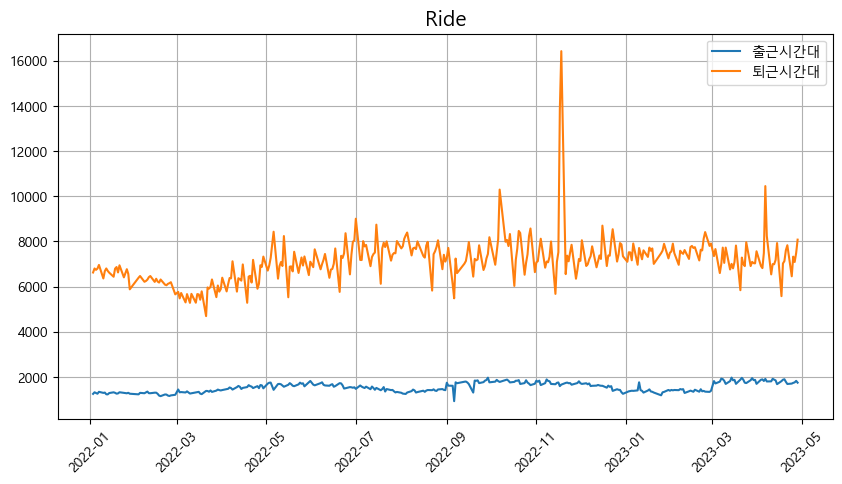

In [64]:
# 승차
plt.figure(figsize=(10,5))
plt.title("Ride", fontsize=15)
plt.plot(centum_riding['년월일'], centum_riding["출근시간"], "-", label = '출근시간대')
plt.plot(centum_riding['년월일'], centum_riding["퇴근시간"], "-", label = '퇴근시간대')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 퇴근시간대 탑승은 18-19시에 가장 많이 이뤄진다.
# 11월 12월 사이에는 유독 크게 퇴근시간대에 탑승이 많이 이뤄진 것을 확인 할 수 있다.
# 10000명이상 퇴근시간대에 승차한 부분 확인

In [98]:
centum_riding.loc[centum_riding['퇴근시간'].sort_values(ascending = False).head(4).index]

,역명,년월일,요일,구분,합계,07시-08시,08시-09시,09시-10시,17시-18시,18시-19시,19시-20시,출근시간,퇴근시간
2838,센텀시티,2022-11-18,금,승차,33949,441,716,505,6325,7608,2495,1662,16428
2836,센텀시티,2022-11-17,목,승차,28271,346,602,648,4553,7021,2266,1596,13840
28156,센텀시티,2023-04-06,목,승차,22873,510,801,605,2725,4961,2767,1916,10453
2778,센텀시티,2022-10-07,금,승차,26950,469,782,530,2542,5272,2484,1781,10298


In [ ]:
# 

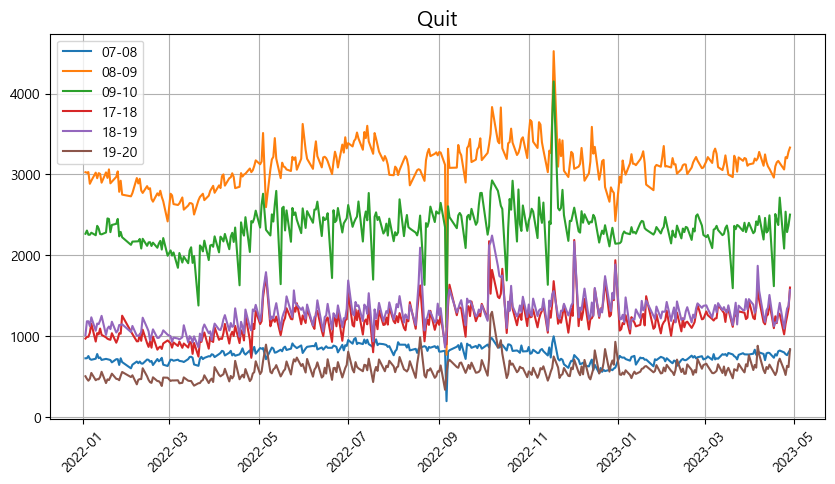

In [66]:
# 하차
plt.figure(figsize=(10,5))
plt.title("Quit", fontsize=15)
plt.plot(centum_quit['년월일'], centum_quit["07시-08시"], "-", label = '07-08')
plt.plot(centum_quit['년월일'], centum_quit["08시-09시"], "-", label = '08-09')
plt.plot(centum_quit['년월일'], centum_quit["09시-10시"], "-", label = '09-10')
plt.plot(centum_quit['년월일'], centum_quit["17시-18시"], "-", label = '17-18')
plt.plot(centum_quit['년월일'], centum_quit["18시-19시"], "-", label = '18-19')
plt.plot(centum_quit['년월일'], centum_quit["19시-20시"], "-", label = '19-20')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

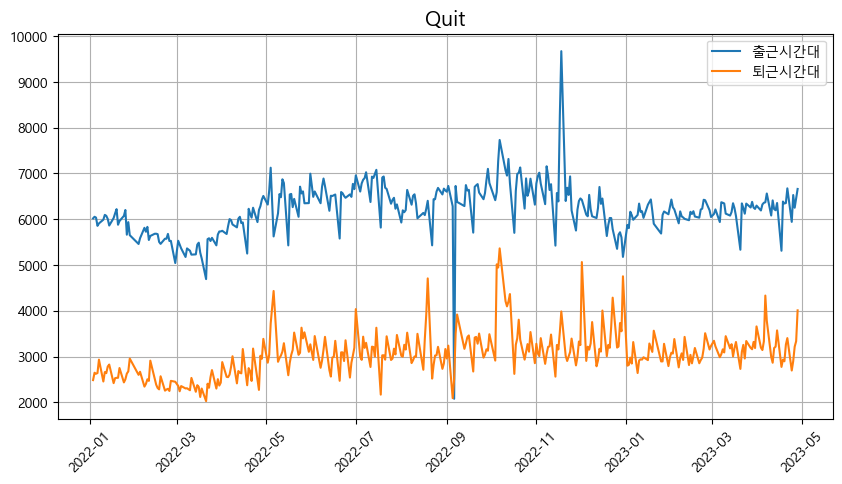

In [67]:
# 하차
plt.figure(figsize=(10,5))
plt.title("Quit", fontsize=15)
plt.plot(centum_quit['년월일'], centum_quit["출근시간"], "-", label = '출근시간대')
plt.plot(centum_quit['년월일'], centum_quit["퇴근시간"], "-", label = '퇴근시간대')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [101]:
centum_quit.loc[centum_quit['출근시간'].sort_values(ascending = True).head(4).index]

,역명,년월일,요일,구분,합계,07시-08시,08시-09시,09시-10시,17시-18시,18시-19시,19시-20시,출근시간,퇴근시간
2733,센텀시티,2022-09-06,화,하차,13121,196,770,1112,899,1070,546,2078,2515
2491,센텀시티,2022-03-21,월,하차,11917,633,2681,1379,747,861,418,4693,2026
2461,센텀시티,2022-02-28,월,하차,14841,631,2419,1994,947,1017,486,5044,2450
2489,센텀시티,2022-03-18,금,하차,13972,650,2504,1991,916,998,388,5145,2302


In [103]:
centum_quit.loc[centum_quit['출근시간'].sort_values(ascending = False).head(4).index]

,역명,년월일,요일,구분,합계,07시-08시,08시-09시,09시-10시,17시-18시,18시-19시,19시-20시,출근시간,퇴근시간
2839,센텀시티,2022-11-18,금,하차,29245,998,4524,4150,1680,1557,749,9672,3986
2837,센텀시티,2022-11-17,목,하차,24767,914,3678,3676,1408,1518,608,8268,3534
2779,센텀시티,2022-10-07,금,하차,26932,973,3833,2926,1819,2244,1301,7732,5364
2787,센텀시티,2022-10-13,목,하차,21743,877,3828,2612,1524,1730,950,7317,4204


In [102]:
centum_quit.loc[centum_quit['퇴근시간'].sort_values(ascending = False).head(4).index]

,역명,년월일,요일,구분,합계,07시-08시,08시-09시,09시-10시,17시-18시,18시-19시,19시-20시,출근시간,퇴근시간
2779,센텀시티,2022-10-07,금,하차,26932,973,3833,2926,1819,2244,1301,7732,5364
20691,센텀시티,2022-12-02,금,하차,22721,766,3069,2589,2189,2167,709,6424,5065
2775,센텀시티,2022-10-05,수,하차,21311,861,3372,2360,2174,2120,721,6593,5015
2777,센텀시티,2022-10-06,목,하차,23658,979,3501,2792,1525,2159,1261,7272,4945


In [ ]:
# 하차부분에서는 08-09 부분에서 가장 많이 이뤄진다. 
# 2022년 9월 6일 출근시간대 하차가 두배정도 차이가 난다.
# 이떄 태풍 힌남노의 영향으로 보여진다. 

## 1.3 주민인구등록 현황 데이터 정제(19~22)

In [110]:
# 부산시 인구 데이터
busan_pop = pd.read_csv(f"{base_url}부산시 인구.csv", sep = '|')
# 필요한 연도만
year_list = ['Dec-22', 'Dec-21', 'Dec-20', 'Dec-19']
busan_pop = busan_pop[busan_pop['rate_year'].isin(year_list)] 
# 연도 컬럼 생성
busan_pop['year'] = busan_pop['rate_year'].str.extract(r'(\d{2})')  # 연도의 앞 2자리 추출
busan_pop['year'] = '20' + busan_pop['year']  # '20'을 앞에 붙이기

# 부산광역시 구별 주민인구 등록 
busan_pop_cnt = busan_pop[busan_pop['gugun'] != '부산광역시']
# 시군구 추출
busan_pop_cnt['시구군'] = busan_pop_cnt['gugun'].apply(lambda x: x[6:])
busan_pop_cnt = busan_pop_cnt[[ 'year', '시구군', 'dong_cnt', 'house_cnt', 'tot_pop_cnt',
       'm_pop_cnt', 'f_pop_cnt', 'pop_ratio', 'pop_density']]
busan_pop_cnt.reset_index(drop = True, inplace = True)

# 부산광역시 주민인구 등록
busan_pop_all = busan_pop[busan_pop['gugun'] == '부산광역시']
busan_pop_all = busan_pop_all[['year', 'gugun', 'dong_cnt', 'house_cnt', 'tot_pop_cnt',
       'm_pop_cnt', 'f_pop_cnt', 'pop_density']]
# 연도별로 정렬
busan_pop_all.sort_values(by='year', ascending=True, inplace = True)
busan_pop_all = busan_pop_all.reset_index(drop = True)

## 1.4 인구 EDA

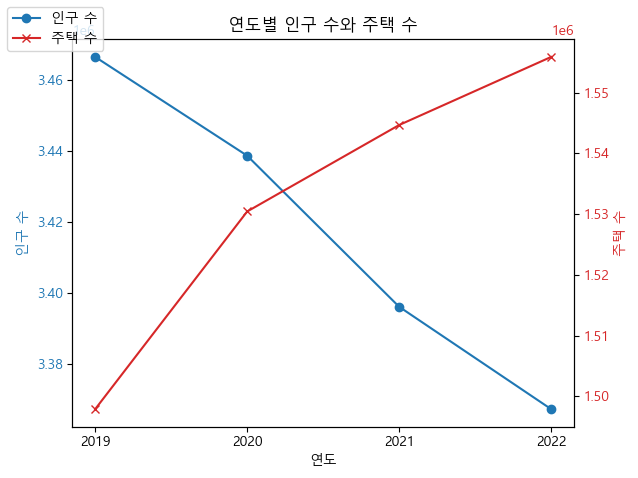

In [126]:
# 첫 번째 축을 생성하고 인구 수 데이터를 추가
fig, ax1 = plt.subplots()

# 첫 번째 축 설정
ax1.set_xlabel('연도')
ax1.set_ylabel('인구 수', color='tab:blue')  # 첫 번째 축 레이블
ax1.plot(busan_pop_all['year'], busan_pop_all['tot_pop_cnt'], color='tab:blue', marker='o', label='인구 수')  # label 설정 추가
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 두 번째 축을 생성하고 주택 수 데이터를 추가
ax2 = ax1.twinx()  # 두 번째 축 생성

# 두 번째 축 설정
ax2.set_ylabel('주택 수', color='tab:red')  # 두 번째 축 레이블
ax2.plot(busan_pop_all['year'], busan_pop_all['house_cnt'], color='tab:red', marker='x', label='주택 수')  # label 설정 추가
ax2.tick_params(axis='y', labelcolor='tab:red')

# 제목과 범례 설정
plt.title('연도별 인구 수와 주택 수')
fig.tight_layout()  # 레이아웃 조정
fig.legend(loc='upper left')  # 범례 표시 (fig.legend()로 범례를 설정합니다)

# 그래프 출력
plt.show()

In [ ]:
# 주택 수는 증가하는 추세이나, 인구 수는 하락하는 추세이다.
# 이 사회적인 현상은 추가적으로 분석이 필요해 보인다.

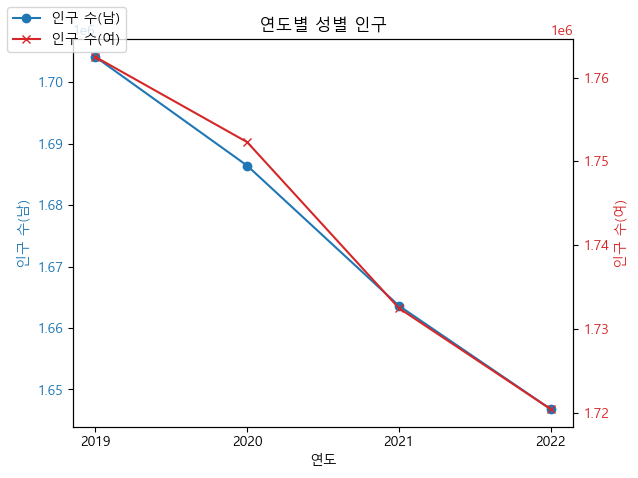

In [129]:
# 첫 번째 축을 생성하고 인구 수 데이터를 추가
fig, ax1 = plt.subplots()

# 첫 번째 축 설정
ax1.set_xlabel('연도')
ax1.set_ylabel('인구 수(남)', color='tab:blue')  # 첫 번째 축 레이블
ax1.plot(busan_pop_all['year'], busan_pop_all['m_pop_cnt'], color='tab:blue', marker='o', label='인구 수(남)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 두 번째 축을 생성하고 주택 수 데이터를 추가
ax2 = ax1.twinx()  # 두 번째 축 생성

# 두 번째 축 설정
ax2.set_ylabel('인구 수(여)', color='tab:red')  # 두 번째 축 레이블
ax2.plot(busan_pop_all['year'], busan_pop_all['f_pop_cnt'], color='tab:red', marker='x', label='인구 수(여)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 제목과 범례 설정
plt.title('연도별 성별 인구')
fig.tight_layout()  # 레이아웃 조정
fig.legend(loc='upper left')  # 범례 표시

# 그래프 출력
plt.show()

In [124]:
# 성별 부분은 여성이 부산광역시에 많이 있는 것을 볼 수있다.
# 전반적으로 하락하는 추세이다.

## 1.5 시군구 EDA

### 1.5.1 지하철

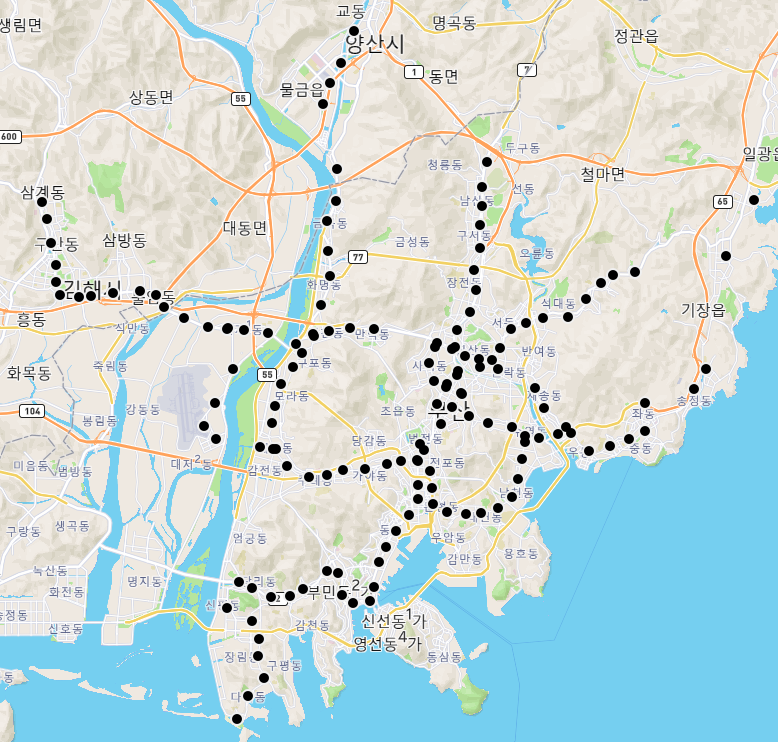


In [219]:
# 지하철 위치
subway_loc = pd.read_csv(f'{base_url}지하철 위치.csv')

# 결측값 삭제
subway_loc = subway_loc.dropna(subset=['ROAD_NM_ADDR'])
# 부산광역시만 추출
busan_subway_loc = subway_loc[subway_loc['ROAD_NM_ADDR'].str.startswith('부산광역시')]
# 필요한 컬럼 추출
busan_subway_loc = busan_subway_loc[['SBW_STATN_NM', 'ROAD_NM_ADDR', 'SBW_STATN_XCRD', 'SBW_STATN_YCRD']]
busan_subway_loc.reset_index(drop = True, inplace = True)
# 시군구 추출
busan_subway_loc['시군구'] = busan_subway_loc['ROAD_NM_ADDR'].str.extract(r'(\w+구)')
busan_subway_loc_cnt = busan_subway_loc['시군구'].value_counts().reset_index()

# 인구 + 지하철역 수
busan_pop_cnt_subway = pd.merge(busan_pop_cnt, busan_subway_loc_cnt, left_on = '시구군', right_on = 'index', how = 'left')

# 결측값을 0으로 대체, 컬럼 전처리
busan_pop_cnt_subway = busan_pop_cnt_subway.fillna(0)
busan_pop_cnt_subway.drop(columns = ['index'], inplace = True)
busan_pop_cnt_subway.rename(columns = {'시군구' : '역개수'}, inplace = True)

### 1.5.2 버스정류장

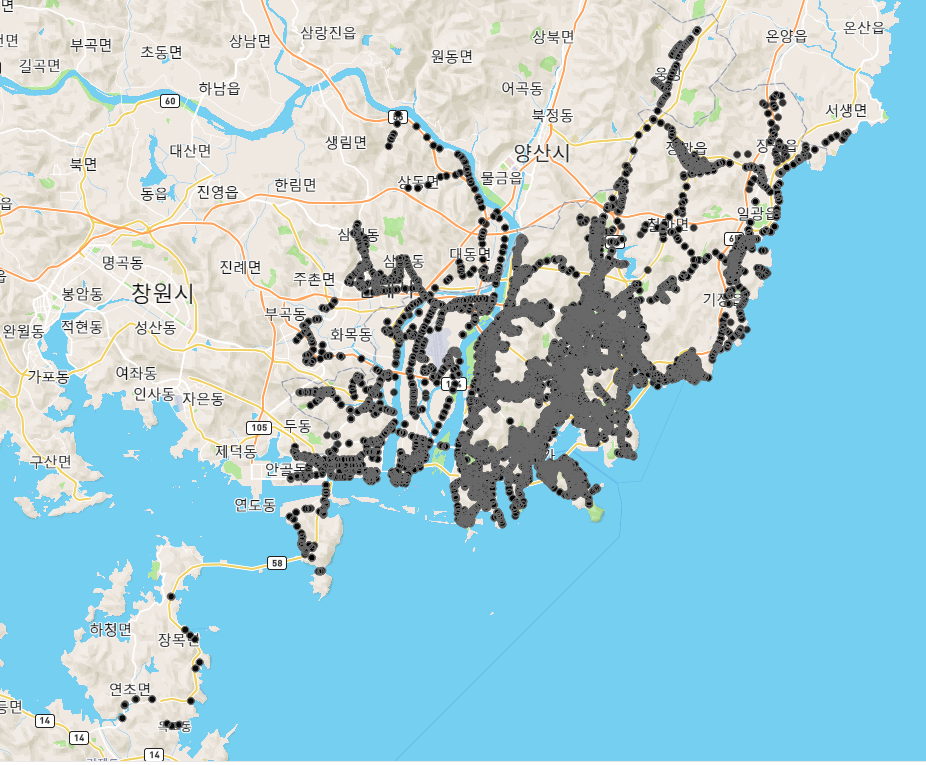

In [225]:
import geopandas as gpd

# 버스 정류장
bus_station = gpd.read_file(f'{base_url}부산광역시_버스 정류소 정보(SHP)/tl_bus_station_info.shp', geometry = 'geometry')
# 시군구 지리 
sigungu = gpd.read_file(f'{base_url}부산_시군구/busan_sigungu.shp', encoding = 'utf-8', geometry = 'geometry')

# 공간 조인 수행
result = gpd.sjoin(sigungu, bus_station, op='contains')

# 각 시군구별 정류장 개수 계산
grouped = result.groupby('SGG_NM').size().reset_index(name='정류장 개수')

busan_pop_cnt_subway_bus = pd.merge(busan_pop_cnt_subway, grouped, left_on = '시구군', right_on = 'SGG_NM', how = 'left')
busan_pop_cnt_subway_bus.drop(columns = ['SGG_NM'], inplace = True)

In [233]:
busan_2022 = busan_pop_cnt_subway_bus[busan_pop_cnt_subway_bus['year'] == '2022']

In [234]:
busan_2022

,year,시구군,dong_cnt,house_cnt,tot_pop_cnt,m_pop_cnt,f_pop_cnt,pop_ratio,pop_density,역개수,정류장 개수
0,2022,중구,9,23960,41909,20725,21184,1.2,14809,3.0,124
1,2022,서구,13,53626,107402,52118,55284,3.2,7699,3.0,312
2,2022,동구,12,46349,88601,43284,45317,2.6,8977,5.0,246
3,2022,영도구,11,54342,110254,54498,55756,3.3,7764,0.0,400
4,2022,부산진구,20,178049,358644,172214,186430,10.7,12088,11.0,662
5,2022,동래구,13,119503,274445,132739,141706,8.2,16503,13.0,563
6,2022,남구,17,117601,262253,128182,134071,7.8,9778,6.0,525
7,2022,북구,13,123569,280940,138213,142727,8.3,7136,13.0,451
8,2022,해운대구,18,170435,391763,187958,203805,11.6,7601,15.0,599
9,2022,사하구,16,140778,306511,152728,153783,9.1,7338,12.0,638


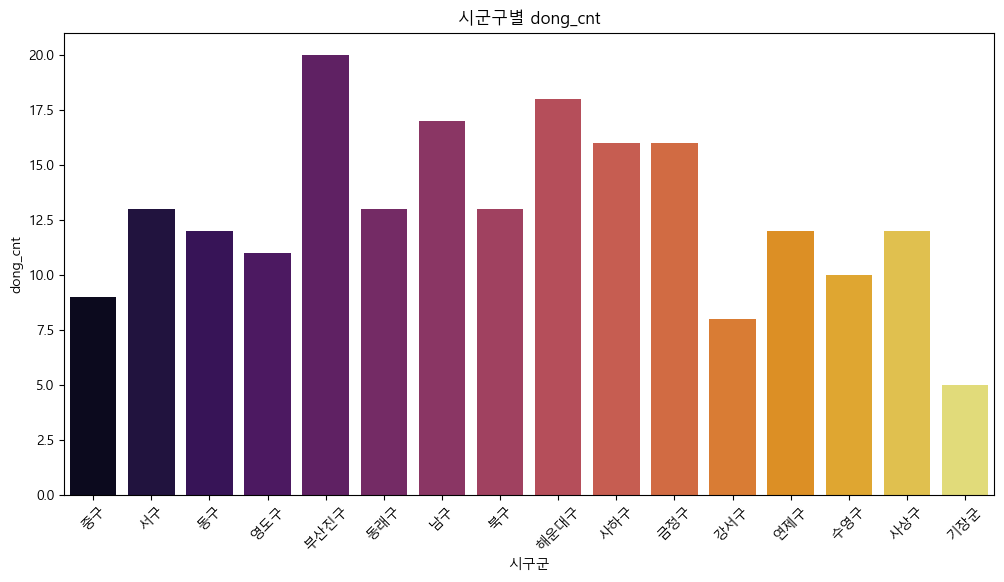

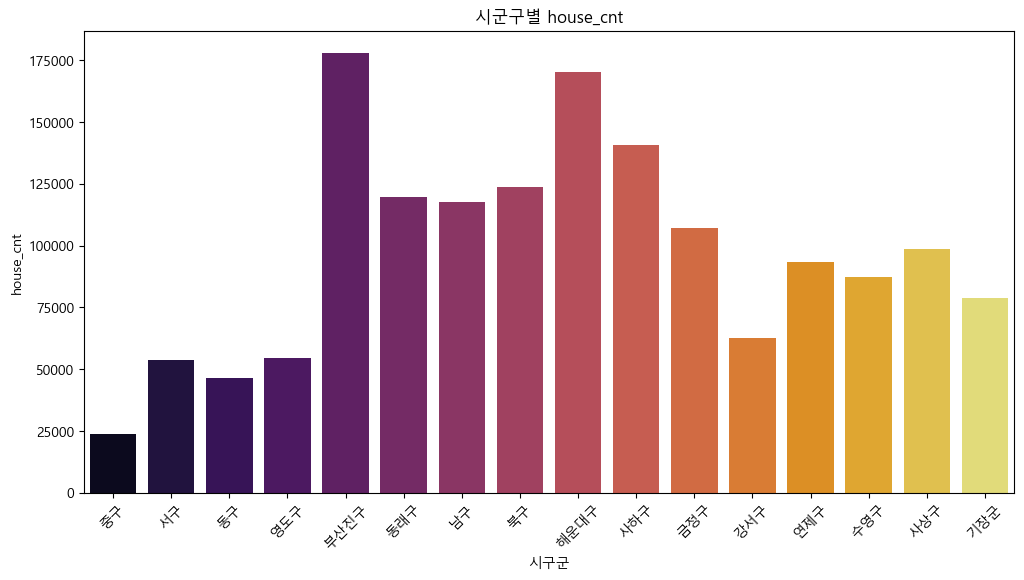

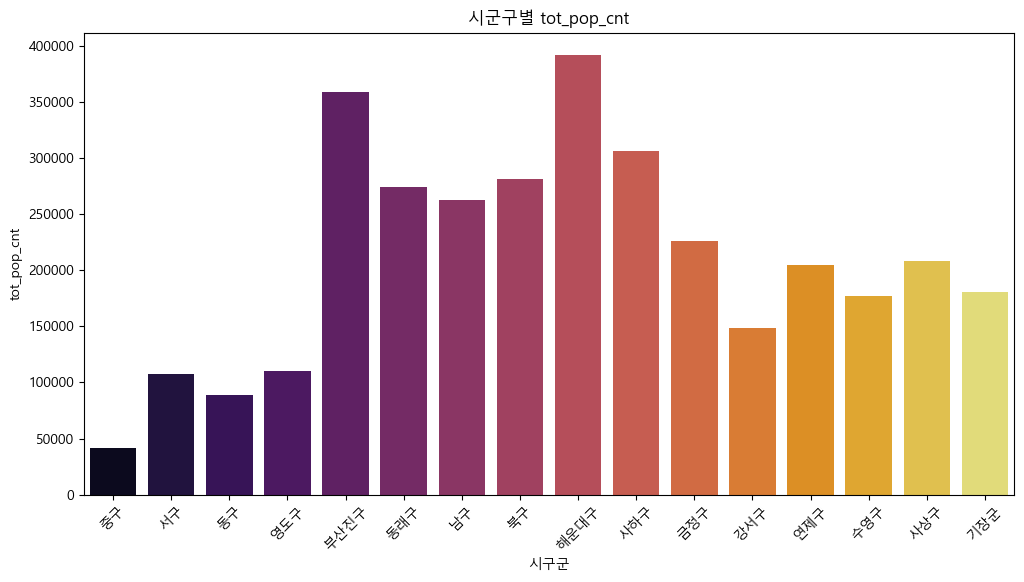

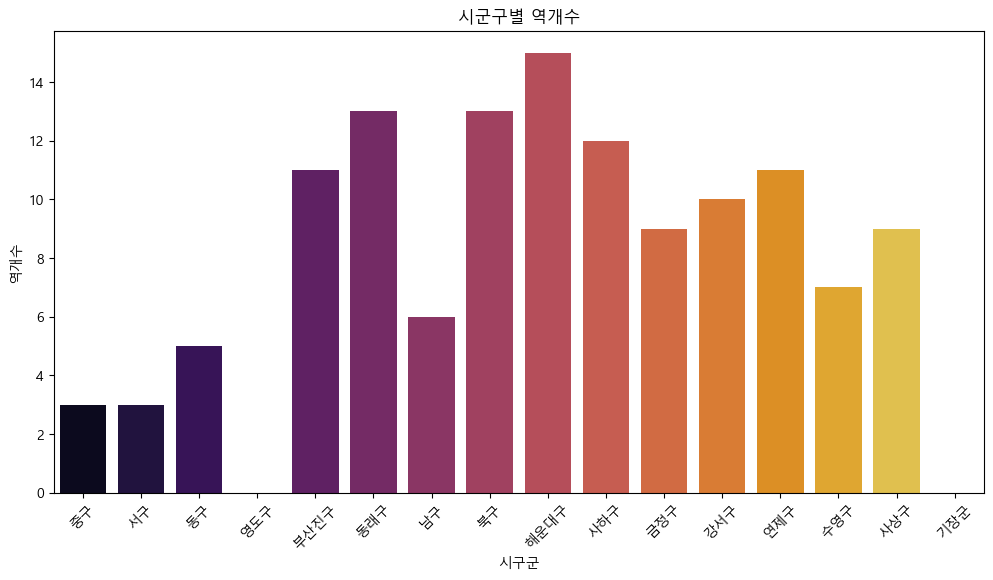

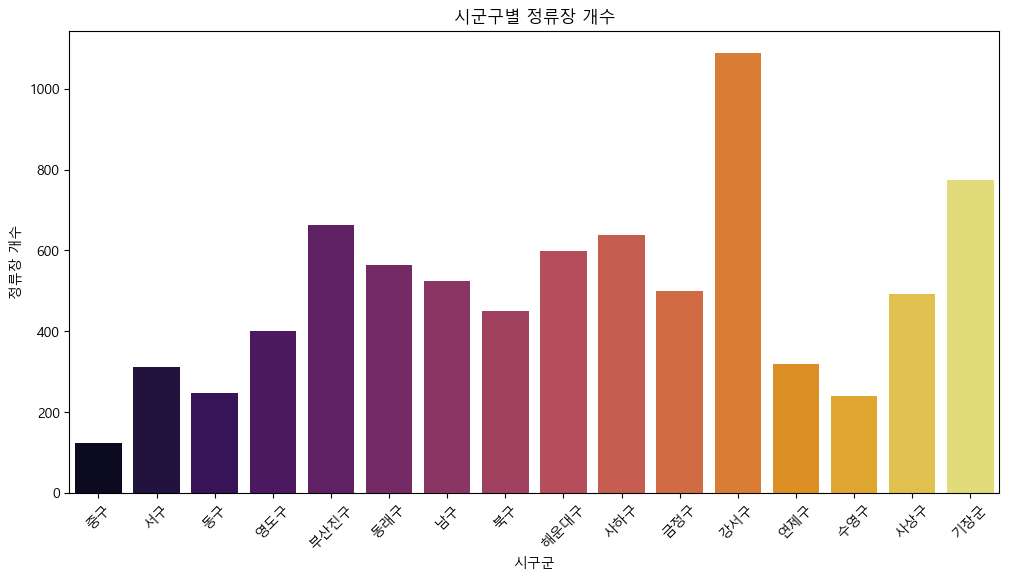

In [239]:
# 시군구별로 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='시구군', y='dong_cnt', data=busan_2022, palette='inferno')
plt.title('시군구별 dong_cnt')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='시구군', y='house_cnt', data=busan_2022, palette='inferno')
plt.title('시군구별 house_cnt')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='시구군', y='tot_pop_cnt', data=busan_2022, palette='inferno')
plt.title('시군구별 tot_pop_cnt')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='시구군', y='역개수', data=busan_2022, palette='inferno')
plt.title('시군구별 역개수')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='시구군', y='정류장 개수', data=busan_2022, palette='inferno')
plt.title('시군구별 정류장 개수')
plt.xticks(rotation=45)
plt.show()

In [238]:
# 강서구에는 정류장 수가 현저히 높다. 
# 관심이 있는 지역은 해운대구, 남구이다. 